In [36]:
import json
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from bs4 import BeautifulSoup
import re

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


## Configuration

In [37]:
# Sliding window parameters
WINDOW = 512       
OVERLAP = 102      # 20% overlap
TOP_K = 10

# Dataset paths
DATASETS = {
    "short": "data/nq_filtered_short.jsonl",
    # "medium": "data/nq_filtered_medium.jsonl",
    # "long": "data/nq_filtered_long.jsonl"
}

# Embedding models to compare
MODELS = {
    "GIST": "avsolatorio/GIST-Embedding-v0",
    "Qwen2.5": "Alibaba-NLP/gte-Qwen2-1.5B-instruct",
    "BGE-M3": "BAAI/bge-m3",
}

## Helper Functions

In [38]:
def sliding_window_chunk(text, window=512, overlap=102):
    """
    Chunk text using sliding window on words (not tokens).
    
    Args:
        text: Raw HTML text as string
        window: Window size in words
        overlap: Overlap size in words
    
    Returns:
        chunks: List of text chunks
        offsets: List of starting word indices
    """
    # Simple word tokenization by splitting on whitespace
    words = text.split()
    
    chunks = []
    offsets = []
    step = window - overlap
    
    i = 0
    while i < len(words):
        chunk_words = words[i:i + window]
        if not chunk_words:
            break
        chunk_text = " ".join(chunk_words)
        chunks.append(chunk_text)
        offsets.append(i)
        i += step
    
    return chunks, offsets

In [39]:
def find_gold_chunk_by_token(document_tokens, offsets, start_token, end_token, window=512):
    """
    Find which chunk contains the gold answer span.
    Maps from official token indices to word-based chunks.
    
    Args:
        document_tokens: List of token dicts from NQ dataset
        offsets: List of chunk starting positions (in words)
        start_token: Start token index of gold answer
        end_token: End token index of gold answer
        window: Window size in words
    
    Returns:
        Chunk index containing the answer, or None if not found
    """
    # Extract just the token strings from document_tokens
    token_strings = [t['token'] for t in document_tokens]
    
    # The gold answer is at token indices [start_token, end_token)
    # We need to find which chunk (based on word positions) contains this
    
    # For simplicity, we'll check if the answer tokens appear in each chunk
    # This is approximate because tokenization != word splitting
    if start_token < 0 or end_token < 0 or start_token >= len(token_strings):
        return None
    
    gold_tokens = token_strings[start_token:end_token]
    gold_text = " ".join(gold_tokens).lower()
    
    # Check each chunk to see if it contains the gold answer
    for idx, chunk_start in enumerate(offsets):
        chunk_end = chunk_start + window
        # Get the word range for this chunk from the original tokenization
        # This is an approximation - we check if gold tokens fall in this range
        if start_token >= chunk_start and start_token < chunk_end:
            return idx
    
    return None

In [40]:
def compute_metrics(rank_list):
    """
    Compute Recall@10 and MRR from a list of ranks.
    
    Args:
        rank_list: List of ranks (1 = best match)
    
    Returns:
        recall10: Recall@10 score
        mrr: Mean Reciprocal Rank
    """
    recall10 = np.mean([1 if r <= 10 else 0 for r in rank_list])
    mrr = np.mean([1.0 / r for r in rank_list])
    return recall10, mrr

## Main Evaluation Function

In [41]:
def evaluate_model_on_dataset(model, dataset_path, dataset_name, window=512, overlap=102):
    """
    Evaluate a single model on a single dataset using raw HTML text.
    
    Args:
        model: SentenceTransformer model
        dataset_path: Path to JSONL dataset
        dataset_name: Name of dataset (for logging)
        window: Window size in words
        overlap: Overlap size in words
    
    Returns:
        Dictionary with metrics and rank_list
    """
    rank_list = []
    skipped = 0
    
    with open(dataset_path, "r", encoding="utf-8") as f:
        for line in tqdm(f, desc=f"Processing {dataset_name}"):
            item = json.loads(line)

            question = item["question_text"]
            
            # Use document_html (raw HTML text) as required
            html_text = item["document_html"]
            
            # Also keep document_tokens for finding gold answer position
            doc_tokens = item["document_tokens"]

            # Sliding window chunking on HTML text
            chunks, offsets = sliding_window_chunk(html_text, window=window, overlap=overlap)
            
            if not chunks:
                skipped += 1
                continue

            # Encode chunks and query
            chunk_embeddings = model.encode(chunks, convert_to_tensor=True, show_progress_bar=False)
            query_embedding = model.encode(question, convert_to_tensor=True, show_progress_bar=False)

            # Similarity ranking
            scores = util.cos_sim(query_embedding, chunk_embeddings)[0]
            ranking = scores.argsort(descending=True).cpu().numpy()

            # Gold answer span location
            ann = item["annotations"][0]
            if ann["short_answers"]:
                gold_start = ann["short_answers"][0]["start_token"]
                gold_end = ann["short_answers"][0]["end_token"]
            else:
                # fallback to long answer
                gold_start = ann["long_answer"]["start_token"]
                gold_end = ann["long_answer"]["end_token"]

            # Skip if no valid answer
            if gold_start < 0 or gold_end < 0:
                skipped += 1
                continue

            gold_chunk = find_gold_chunk_by_token(doc_tokens, offsets, gold_start, gold_end, window=window)
            if gold_chunk is None or gold_chunk >= len(chunks):
                skipped += 1
                continue

            # Find rank of gold chunk
            gold_rank = np.where(ranking == gold_chunk)[0][0] + 1
            rank_list.append(gold_rank)
    
    # Compute metrics
    if rank_list:
        recall10, mrr = compute_metrics(rank_list)
    else:
        recall10, mrr = 0.0, 0.0
    
    return {
        "recall@10": recall10,
        "mrr": mrr,
        "rank_list": rank_list,
        "total_samples": len(rank_list),
        "skipped": skipped
    }

## Run Experiments

This will evaluate all models on all datasets. **Note:** This may take a while depending on your hardware.

In [42]:
# Store all results
results = {}

for model_name, model_path in MODELS.items():
    print(f"\n{'='*60}")
    print(f"Loading model: {model_name}")
    print(f"{'='*60}\n")
    
    try:
        # Load model
        model = SentenceTransformer(model_path, device=device)
        
        results[model_name] = {}
        
        # Evaluate on each dataset
        for dataset_name, dataset_path in DATASETS.items():
            print(f"\nEvaluating on {dataset_name} dataset...")
            
            metrics = evaluate_model_on_dataset(
                model=model,
                dataset_path=dataset_path,
                dataset_name=dataset_name,
                window=WINDOW,
                overlap=OVERLAP
            )
            
            results[model_name][dataset_name] = metrics
            
            print(f"Results for {model_name} on {dataset_name}:")
            print(f"  Recall@10: {metrics['recall@10']:.4f}")
            print(f"  MRR: {metrics['mrr']:.4f}")
            print(f"  Samples: {metrics['total_samples']} (Skipped: {metrics['skipped']})")
        
        # Clean up model to free memory
        del model
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
    except Exception as e:
        print(f"Error loading or evaluating {model_name}: {str(e)}")
        results[model_name] = {dataset: {"error": str(e)} for dataset in DATASETS.keys()}

print("\n" + "="*60)
print("All experiments completed!")
print("="*60)


Loading model: GIST


Evaluating on short dataset...

Evaluating on short dataset...


Processing short: 80it [00:18,  4.41it/s]



Results for GIST on short:
  Recall@10: 0.8065
  MRR: 0.3344
  Samples: 31 (Skipped: 49)

Loading model: Qwen2.5



Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 33.59it/s]




Evaluating on short dataset...


Processing short: 0it [00:00, ?it/s]



Error loading or evaluating Qwen2.5: Invalid buffer size: 79.76 GiB

Loading model: BGE-M3


Evaluating on short dataset...

Evaluating on short dataset...


Processing short: 0it [00:01, ?it/s]

Error loading or evaluating BGE-M3: Invalid buffer size: 52.00 GiB

All experiments completed!


## Results Analysis

In [43]:
# Create summary DataFrame
summary_data = []

# Debug: Check if results exist
print(f"Number of models in results: {len(results)}")
print(f"Models: {list(results.keys())}")

for model_name in results.keys():
    for dataset_name in DATASETS.keys():
        if "error" not in results[model_name][dataset_name]:
            summary_data.append({
                "Model": model_name,
                "Dataset": dataset_name,
                "Recall@10": results[model_name][dataset_name]["recall@10"],
                "MRR": results[model_name][dataset_name]["mrr"],
                "Samples": results[model_name][dataset_name]["total_samples"]
            })
        else:
            print(f"Error in {model_name} - {dataset_name}: {results[model_name][dataset_name]['error']}")

# Check if we have data
if not summary_data:
    print("\n⚠️ WARNING: No valid results to display!")
    print("Please make sure the experiment cell (cell 10) has been run successfully.")
    print("Check the output of that cell for any errors.")
else:
    df_summary = pd.DataFrame(summary_data)
    print("\n=== Summary Results ===")
    print(df_summary.to_string(index=False))

    # Save to CSV
    df_summary.to_csv("embedding_comparison_results.csv", index=False)
    print("\nResults saved to embedding_comparison_results.csv")

Number of models in results: 3
Models: ['GIST', 'Qwen2.5', 'BGE-M3']
Error in Qwen2.5 - short: Invalid buffer size: 79.76 GiB
Error in BGE-M3 - short: Invalid buffer size: 52.00 GiB

=== Summary Results ===
Model Dataset  Recall@10      MRR  Samples
 GIST   short   0.806452 0.334355       31

Results saved to embedding_comparison_results.csv


## Visualizations

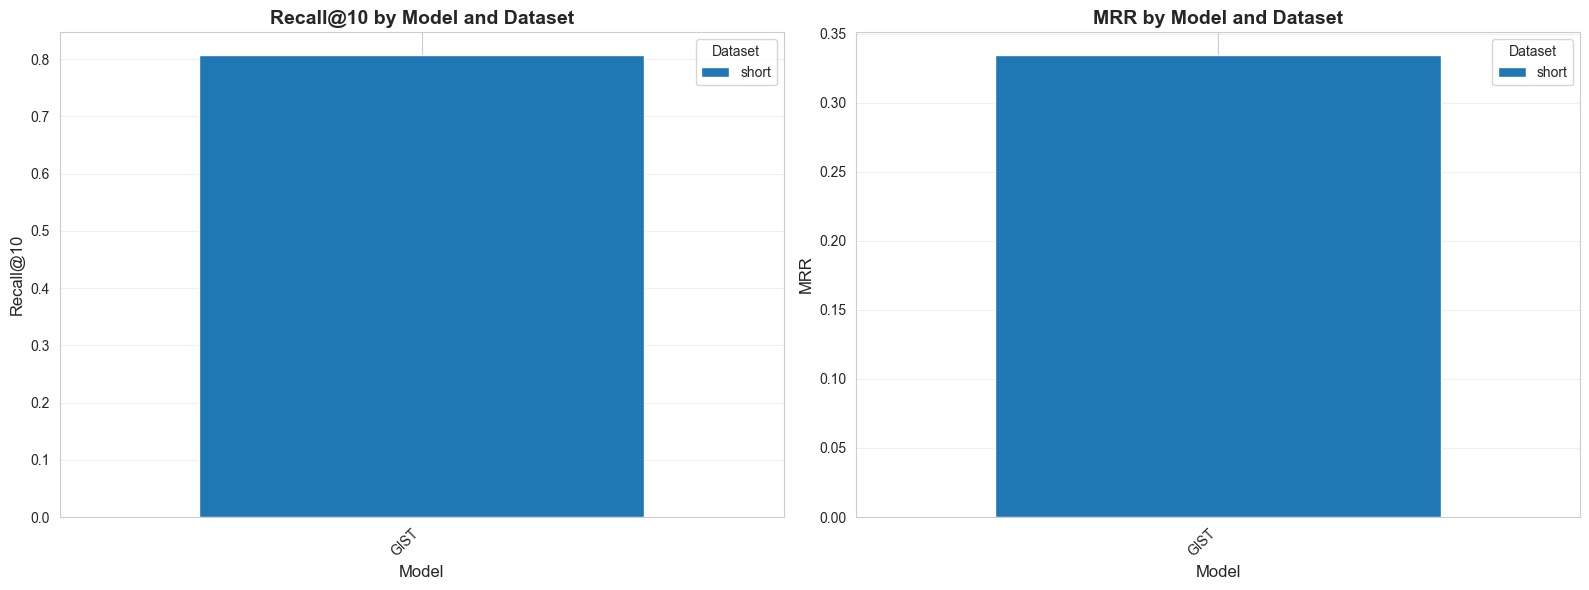

Visualization saved to embedding_comparison_results.png


In [44]:
# Check if df_summary exists and has data
if 'df_summary' not in locals() or df_summary.empty:
    print("⚠️ No data to visualize. Please run the experiment cell (cell 10) first.")
else:
    # Set style
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (14, 6)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Recall@10
    recall_pivot = df_summary.pivot(index="Model", columns="Dataset", values="Recall@10")
    recall_pivot.plot(kind="bar", ax=axes[0], width=0.8)
    axes[0].set_title("Recall@10 by Model and Dataset", fontsize=14, fontweight='bold')
    axes[0].set_ylabel("Recall@10", fontsize=12)
    axes[0].set_xlabel("Model", fontsize=12)
    axes[0].legend(title="Dataset", fontsize=10)
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

    # Plot 2: MRR
    mrr_pivot = df_summary.pivot(index="Model", columns="Dataset", values="MRR")
    mrr_pivot.plot(kind="bar", ax=axes[1], width=0.8)
    axes[1].set_title("MRR by Model and Dataset", fontsize=14, fontweight='bold')
    axes[1].set_ylabel("MRR", fontsize=12)
    axes[1].set_xlabel("Model", fontsize=12)
    axes[1].legend(title="Dataset", fontsize=10)
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig("embedding_comparison_results.png", dpi=300, bbox_inches='tight')
    plt.show()

    print("Visualization saved to embedding_comparison_results.png")

## Best Model Analysis

In [45]:
# Check if df_summary exists and has data
if 'df_summary' not in locals() or df_summary.empty:
    print("⚠️ No data to analyze. Please run the experiment cell (cell 10) first.")
else:
    # Calculate average performance across all datasets
    avg_performance = df_summary.groupby("Model")[["Recall@10", "MRR"]].mean()
    avg_performance = avg_performance.sort_values("Recall@10", ascending=False)

    print("\n=== Average Performance Across All Datasets ===")
    print(avg_performance)

    best_model = avg_performance.index[0]
    print(f"\n🏆 Best performing model: {best_model}")
    print(f"   Average Recall@10: {avg_performance.loc[best_model, 'Recall@10']:.4f}")
    print(f"   Average MRR: {avg_performance.loc[best_model, 'MRR']:.4f}")


=== Average Performance Across All Datasets ===
       Recall@10       MRR
Model                     
GIST    0.806452  0.334355

🏆 Best performing model: GIST
   Average Recall@10: 0.8065
   Average MRR: 0.3344


## Detailed Analysis by Document Length

In [46]:
# Check if df_summary exists and has data
if 'df_summary' not in locals() or df_summary.empty:
    print("⚠️ No data to analyze. Please run the experiment cell (cell 10) first.")
else:
    # Analyze performance trend across document lengths
    for metric in ["Recall@10", "MRR"]:
        print(f"\n=== {metric} by Document Length ===")
        metric_pivot = df_summary.pivot(index="Model", columns="Dataset", values=metric)
        
        # Only include columns that exist
        available_cols = [col for col in ["short", "medium", "long"] if col in metric_pivot.columns]
        if available_cols:
            metric_pivot = metric_pivot[available_cols]
            print(metric_pivot.to_string())
            
            # Calculate degradation from short to long (if both exist)
            if "short" in metric_pivot.columns and "long" in metric_pivot.columns:
                degradation = ((metric_pivot["short"] - metric_pivot["long"]) / metric_pivot["short"] * 100)
                print(f"\nPerformance degradation (short → long):")
                for model in degradation.index:
                    print(f"  {model}: {degradation[model]:.2f}%")
        else:
            print("No data available for length comparison.")


=== Recall@10 by Document Length ===
Dataset     short
Model            
GIST     0.806452

=== MRR by Document Length ===
Dataset     short
Model            
GIST     0.334355
